# Chapter 11. Deep Learning in Chemistry

## 11.2. Multilayer Perceptron (MLP)

In this section, we will explore the structure of a MLP, and use MLP network to solve more complex regression and classification problems.

### 11.2.1. Structure of MLP Network

The structure of a MLP network can be described as follow:

![MLP structure](images/MLP_structure.png)

**Key points to remember about MLP network**

- MLP can solve comlex problems with non-linearity, which a single perceptron can not.
- MLP contains 1 or multiple hidden layers and 1 output layer. Each layer has a defined number of perceptrons (neurons) in it.
- Each neurons contains the weights (w) for each of its inputs, and a bias (b).
- The output of a neuron is calculated using the following equation:

 $$\text{output} = \sum_{i}(w_i \times x_i) + b$$

- The output of a neuron should be passed through an activation function. Activation function has many purposes in neural network, such as mapping the values to a new desired range, and introducing non-linearity to the network.
- Some commonly used activation function in ANN are:
![Activation functions](images/activation_functions.png)
- The input and output values of the network should be scaled to small range for gradient descent to work.

### 11.2.2. How MLP Network Works

The workflow of an MLP network is similar to a single-perceptron network, which includes the following steps:
- **Step 1.** Initialize parameters
- **Step 2.** Forward pass
- **Step 3.** Calculate the value of the loss function
- **Step 4.** Backward pass
- **Step 5.** Update parameters.
- Return to **Step 2**, repeat after a number of iterations (epochs) or until the loss function is low enough.

During the backward pass, the change chain rule is applied to calculate the gradients through activation functions. For example:
![Backpropagation - Activation functions](images/backpropagation_activation_function.png)

Because the gradient flows through activation function, **the first derivative of the activation function must exist** in order for backpropagation to work.

### 11.2.3. PyTorch Implementation of MLP

#### 11.2.3.1. MLP network with 1 input, 1 hidden layer containing 5 neurons, 1 output

In this section, we will build an MLP network to perform regression for non-linear function y=f(x)

*Network structure:*
![MLP network](images/MLP_1_5_1.png)

**a. Import modules**

In [1]:
# Import modules
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

**b. Load data**

In [2]:
# Define the data points
x = np.linspace(0, 10, 11)
y = x*x*x - 10*x*x + 25

In [3]:
# Define input and output scalers
input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data to the range from 0 to 1
x_scaled = input_scaler.fit_transform(x.reshape(-1, 1)).reshape(-1)
y_scaled = output_scaler.fit_transform(y.reshape(-1, 1)).reshape(-1)

In [4]:
# Convert to tensor
x_scaled = torch.tensor(x_scaled).float()
y_scaled = torch.tensor(y_scaled).float()

**c. Create model**

In [5]:
# Define the regression class
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.hidden = nn.Linear(1, 5)  # 1 input and 5 hidden
        self.output = nn.Linear(5, 1)  # 5 hidden and 1 output

    def forward(self, x):
        x = self.hidden(x)
        x = torch.sigmoid(x)
        return self.output(x)

In [6]:
# Instantiate the model
model = RegressionModel()

**d. Training**

In [7]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

C:\python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [8]:
# Define the train function
def train(x, y):
    # Forward pass
    outputs = model(x.unsqueeze(1))
    loss = criterion(outputs, y.unsqueeze(1))
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [9]:
# Create lists of losses for visualization
losses = []

# Train the model
num_epochs = 10000
progress_bar = tqdm(range(num_epochs))
for epoch in progress_bar:
    train_loss = train(x_scaled, y_scaled)
    
    # Add loss to lists for visualization
    losses.append(train_loss)
        
    # Print progress
    progress_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}') 

Epoch [10000/10000], Train loss: 0.0000: 100%|██████████████████████████████████| 10000/10000 [00:12<00:00, 806.79it/s]


**e. Visualization**

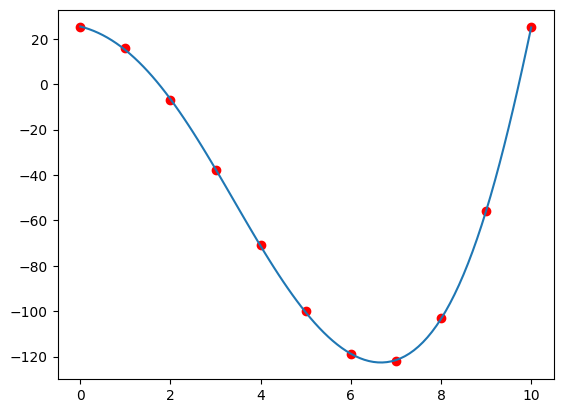

In [10]:
# Axis limits
x_min = math.floor(min(x))
x_max = math.ceil(max(x))
y_min = math.floor(min(y))
y_max = math.ceil(max(y))

# Create the plot
x_values = np.linspace(x_min, x_max, num=101)
x_values_scaled = input_scaler.transform(x_values.reshape(-1, 1)).reshape(-1)
y_values_scaled = model(torch.tensor(x_values_scaled).float().unsqueeze(1))
y_values_scaled = y_values_scaled.detach().numpy()
y_values = output_scaler.inverse_transform(y_values_scaled.reshape(-1, 1)).reshape(-1)

fig = plt.figure()
plt.scatter(x, y, color='red')
plt.plot(x_values, y_values)
plt.show()

Text(0, 0.5, 'MSE loss')

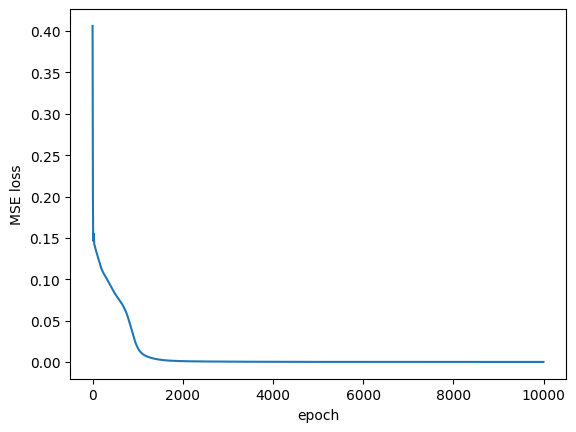

In [11]:
# Visualize MSE loss values over time
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('MSE loss')

**f. Make prediction**

In [12]:
# Input for prediction
x_pred = 5

# Scale input to range 0 to 1
x_pred_scaled = input_scaler.transform([[x_pred]])

# Convert to tensor
x_pred_scaled = torch.tensor(x_pred_scaled).float()

# Run model forward
y_pred_scaled = model(x_pred_scaled)

# Convert back to number
y_pred_scaled = y_pred_scaled.item()

# Scale output back to original range
y_pred = output_scaler.inverse_transform([[y_pred_scaled]])[0][0]

# Show result
print(y_pred)

-100.49758613109587


**g. Save and load model**

In [13]:
# Save model
model_name = 'model_3'
file_name = f'.\\{model_name}_{num_epochs}.ckpt'
torch.save(model.state_dict(), file_name)

In [14]:
# Load model
file_name = f'.\\{model_name}_10000.ckpt'
loaded_model = RegressionModel()
loaded_model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

#### 11.2.3.2. MLP network with 3 inputs, 2 hidden layers containing 5 neurons each, 2 outputs

In this section, we will build an MLP network to perform regression for non-linear function with multiple inputs and outputs $(y_1, y_2) = f(x_1, x_2, x_3)$

*Network structure:*
![MLP network](images/MLP_3_5_5_2.png)

**a. Import modules**

In [15]:
# Import modules
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

**b. Load data**

In [16]:
# Define the data points
np.random.seed(42)
x1 = np.random.rand(10)
x2 = np.random.rand(10)
x3 = np.random.rand(10)
y1 = x1*x1*x2 - 5*x2*x3 + 5
y2 = x3*x1 + 8*x2*x1 - 15

In [17]:
# Combine inputs into 1 array
x = np.column_stack((x1, x2, x3))

# Combine outputs into 1 array
y = np.column_stack((y1, y2))

# Define input and output scalers
input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data to the range from 0 to 1
x_scaled = input_scaler.fit_transform(x)
y_scaled = output_scaler.fit_transform(y)

# Convert to tensor
x_scaled = torch.tensor(x_scaled).float()
y_scaled = torch.tensor(y_scaled).float()

**c. Create model**

In [18]:
# Define regression class
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.hidden1 = nn.Linear(3, 5)  # 3 input and 5 hidden
        self.hidden2 = nn.Linear(5, 5)  # 5 hidden and 5 hidden
        self.output = nn.Linear(5, 2)  # 5 hidden and 2 output

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.hidden2(x)
        x = torch.sigmoid(x)
        return self.output(x)

In [19]:
# Instantiate the model
model = RegressionModel()

**d. Training**

In [20]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [21]:
# Define the train function
def train(x, y):
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [22]:
# Create lists of losses for visualization
losses = []

# Train the model
num_epochs = 5000
progress_bar = tqdm(range(num_epochs))
for epoch in progress_bar:
    train_loss = train(x_scaled, y_scaled)
    
    # Add loss to lists for visualization
    losses.append(train_loss)
        
    # Print progress
    progress_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}') 

Epoch [5000/5000], Train loss: 0.0000: 100%|██████████████████████████████████████| 5000/5000 [00:06<00:00, 746.21it/s]


**e. Visualization**

Text(0, 0.5, 'MSE loss')

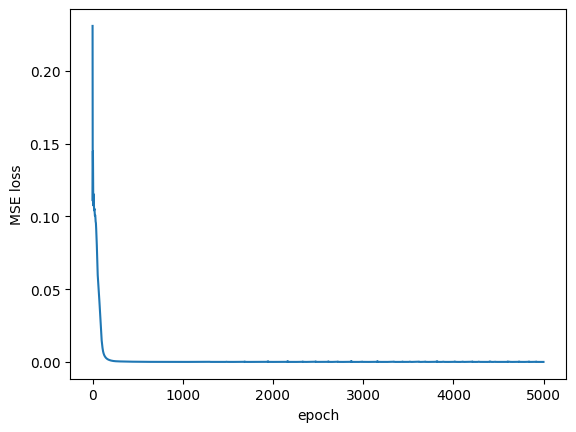

In [23]:
# Visualize MSE loss values over time
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('MSE loss')

**f. Make prediction**

In [24]:
# Input for prediction
x_pred = [8, 3, 4]

# Scale input to range 0 to 1
x_pred_scaled = input_scaler.transform([x_pred])

# Convert to tensor
x_pred_scaled = torch.tensor(x_pred_scaled).float()

# Run model forward
y_pred_scaled = model(x_pred_scaled)

# Convert back to number
y_pred_scaled = y_pred_scaled.detach().numpy()

# Scale output back to original range
y_pred = output_scaler.inverse_transform(y_pred_scaled)[0]

# Show result
print(y_pred)

[ 4.977021 -8.363491]


**g. Save and load model**

In [25]:
# Save model
model_name = '.\\model_4'
file_name = f'.\\{model_name}_{num_epochs}.ckpt'
torch.save(model.state_dict(), file_name)

In [26]:
# Load model
file_name = f'.\\{model_name}_5000.ckpt'
loaded_model = RegressionModel()
loaded_model.load_state_dict(torch.load(file_name))

<All keys matched successfully>